# Q5: Analysis (20 points)
By now you should know how to train networks from scratch or using from pre-trained models. You should also understand the relative performance in either scenarios. Needless to say, the performance of these models is stronger than previous non-deep architectures used until 2012. However, final performance is not the only metric we care about. It is important to get some intuition of what these models are really learning. Lets try some standard techniques.


**FEEL FREE TO WRITE UTIL CODE IN ANOTHER FILE AND IMPORT IN THIS NOTEBOOK FOR EASE OF READABILITY**

## 5.1 Nearest Neighbors (7 pts)
Pick 3 images from PASCAL test set from different classes, and compute 4 nearest neighbors over the entire test set for each of them. You should compare the following feature representations to find the nearest neighbors:
1. The features before the final fc layer from the ResNet (finetuned from ImageNet). It is the features right before the final class label output.
2. pool5 features from the CaffeNet (trained from scratch)

You may use the [this nearest neighbor function](https://scikit-learn.org/stable/modules/neighbors.html).
Plot the raw images of the ones you picked and their nearest neighbors.

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt
%matplotlib inline

import trainer
import numpy as np
from utils import ARGS
from utils import get_data_loader
from simple_cnn import SimpleCNN, get_fc
from voc_dataset import VOCDataset
from sklearn.neighbors import NearestNeighbors

In [81]:
class CaffeNet(nn.Module):
    def __init__(self, num_classes=20, inp_size=224, c_dim=3):
        super().__init__()
        self.num_classes = num_classes
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        self.conv1 = nn.Conv2d(3, 96, 11, stride=4, padding=0)
        self.conv2 = nn.Conv2d(96, 256, 5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(256, 384, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(384, 384, 3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(384, 256, 3, stride=1, padding=1)
        
        self.nonlinear = nn.ReLU()
        
        self.pool = nn.MaxPool2d(3, 2)
        
        self.dropout = nn.Dropout(p=0.5)
        
        self.flat_dim = (int)(256*(5)*(5))
        
        self.fc1 = nn.Sequential(*get_fc(self.flat_dim, 4096, 'relu'))
        self.fc2 = nn.Sequential(*get_fc(4096,  4096, 'relu'))
        self.fc3 = nn.Sequential(*get_fc(4096, 20, 'none'))
        
    def forward(self, x):
        N = x.size(0)
        x = self.conv1(x)
        x = self.nonlinear(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.nonlinear(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.nonlinear(x)
        
        x = self.conv4(x)
        x = self.nonlinear(x)
        
        x = self.conv5(x)
        x = self.nonlinear(x)
        x = self.pool(x)
        
        flat_x = x.view(N, self.flat_dim)
        out = self.fc1(flat_x)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.fc3(out)
        
        return x

In [82]:
# Load all the test images. Pick 3 indices.
test_loader = get_data_loader('voc', train=False, batch_size=ARGS.test_batch_size, split='test', inp_size=ARGS.inp_size)
device =  torch.device("cuda" if ARGS.use_cuda else "cpu")
model = CaffeNet().to(device)
model_name = 'CaffeNet'
filename = 'checkpoint-{}-epoch{}.pth'.format(
        model_name, 50)
model.load_state_dict(torch.load(filename))
model.eval()

pred = []
all_data = []
for data, _, _ in test_loader:
    data = data.to(device)
    output = model(data)
    pred.append(output.detach().cpu().numpy())
    all_data.append(data.cpu().numpy())
pred = np.concatenate(pred)
data = np.concatenate(all_data)

# Calculate the features for all the test images.

# Fine the nearest neighbors for the 3 images you picked.

# Plot the images and their neighbors.

In [83]:
# CaffeNet()
pred = pred[:,:,0,0] ##squeeze dimensions
near_n = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(pred)
_, indices1 = near_n.kneighbors(pred[15,:].reshape(1,-1)) #cat
_, indices2 = near_n.kneighbors(pred[96,:].reshape(1,-1)) #bus
_, indices3 = near_n.kneighbors(pred[301,:].reshape(1,-1)) #car


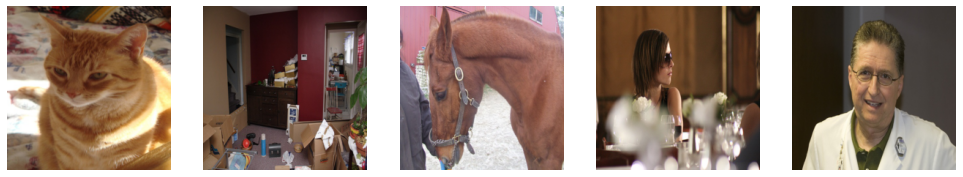

In [84]:
fig1, ax1 = plt.subplots(1,5)
fig1.set_figwidth(17)

for i, index in enumerate(indices1[0]):
    image = data[index, :]
    image = np.moveaxis(image, 0, -1)
    ax1[i].axis("off")
    ax1[i].imshow(image)
plt.show()

(4952, 3, 224, 224)
(224, 224, 3)


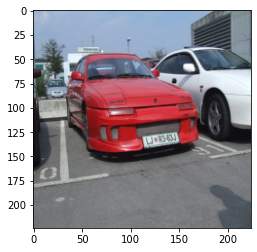

In [85]:
print(np.shape(data))
image = data[301,:]
# image = image.cpu().numpy()
image = np.moveaxis(image, 0, -1)
print(np.shape(image))
plt.imshow(image)

In [103]:
class PretrainedResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        self.model = nn.Sequential(*list(self.model.children())[:-1])
        self.flat_dim = 512
        self.fc = nn.Linear(512, 20) #NOT SURE ABOUT THIS (512, 20)
    
    def forward(self, x):
        N = x.size(0)
        x = self.model(x)
        flat_x = x.view(N, self.flat_dim)
        out = self.fc(flat_x)
        return x

In [104]:
test_loader = get_data_loader('voc', train=False, batch_size=ARGS.test_batch_size, split='test', inp_size=ARGS.inp_size)
device =  torch.device("cuda" if ARGS.use_cuda else "cpu")
model = PretrainedResNet().to(device)

# resnet = models.resnet18(pretrained=True)
# resnet = nn.Sequential(*list(resnet.children())[:-1])

# model = resnet.to(device)
model_name = 'ResNet_Pretrained_True'
filename = 'checkpoint-{}-epoch{}.pth'.format(
        model_name, 50)
model.load_state_dict(torch.load(filename))
model.eval()

pred = []
all_data = []
for data, _, _ in test_loader:
    data = data.to(device)
    output = model(data)
    pred.append(output.detach().cpu().numpy())
    all_data.append(data.cpu().numpy())
pred = np.concatenate(pred)
data = np.concatenate(all_data)

RuntimeError: Error(s) in loading state_dict for PretrainedResNet:
	Missing key(s) in state_dict: "model.0.weight", "model.1.weight", "model.1.bias", "model.1.running_mean", "model.1.running_var", "model.4.0.conv1.weight", "model.4.0.bn1.weight", "model.4.0.bn1.bias", "model.4.0.bn1.running_mean", "model.4.0.bn1.running_var", "model.4.0.conv2.weight", "model.4.0.bn2.weight", "model.4.0.bn2.bias", "model.4.0.bn2.running_mean", "model.4.0.bn2.running_var", "model.4.1.conv1.weight", "model.4.1.bn1.weight", "model.4.1.bn1.bias", "model.4.1.bn1.running_mean", "model.4.1.bn1.running_var", "model.4.1.conv2.weight", "model.4.1.bn2.weight", "model.4.1.bn2.bias", "model.4.1.bn2.running_mean", "model.4.1.bn2.running_var", "model.5.0.conv1.weight", "model.5.0.bn1.weight", "model.5.0.bn1.bias", "model.5.0.bn1.running_mean", "model.5.0.bn1.running_var", "model.5.0.conv2.weight", "model.5.0.bn2.weight", "model.5.0.bn2.bias", "model.5.0.bn2.running_mean", "model.5.0.bn2.running_var", "model.5.0.downsample.0.weight", "model.5.0.downsample.1.weight", "model.5.0.downsample.1.bias", "model.5.0.downsample.1.running_mean", "model.5.0.downsample.1.running_var", "model.5.1.conv1.weight", "model.5.1.bn1.weight", "model.5.1.bn1.bias", "model.5.1.bn1.running_mean", "model.5.1.bn1.running_var", "model.5.1.conv2.weight", "model.5.1.bn2.weight", "model.5.1.bn2.bias", "model.5.1.bn2.running_mean", "model.5.1.bn2.running_var", "model.6.0.conv1.weight", "model.6.0.bn1.weight", "model.6.0.bn1.bias", "model.6.0.bn1.running_mean", "model.6.0.bn1.running_var", "model.6.0.conv2.weight", "model.6.0.bn2.weight", "model.6.0.bn2.bias", "model.6.0.bn2.running_mean", "model.6.0.bn2.running_var", "model.6.0.downsample.0.weight", "model.6.0.downsample.1.weight", "model.6.0.downsample.1.bias", "model.6.0.downsample.1.running_mean", "model.6.0.downsample.1.running_var", "model.6.1.conv1.weight", "model.6.1.bn1.weight", "model.6.1.bn1.bias", "model.6.1.bn1.running_mean", "model.6.1.bn1.running_var", "model.6.1.conv2.weight", "model.6.1.bn2.weight", "model.6.1.bn2.bias", "model.6.1.bn2.running_mean", "model.6.1.bn2.running_var", "model.7.0.conv1.weight", "model.7.0.bn1.weight", "model.7.0.bn1.bias", "model.7.0.bn1.running_mean", "model.7.0.bn1.running_var", "model.7.0.conv2.weight", "model.7.0.bn2.weight", "model.7.0.bn2.bias", "model.7.0.bn2.running_mean", "model.7.0.bn2.running_var", "model.7.0.downsample.0.weight", "model.7.0.downsample.1.weight", "model.7.0.downsample.1.bias", "model.7.0.downsample.1.running_mean", "model.7.0.downsample.1.running_var", "model.7.1.conv1.weight", "model.7.1.bn1.weight", "model.7.1.bn1.bias", "model.7.1.bn1.running_mean", "model.7.1.bn1.running_var", "model.7.1.conv2.weight", "model.7.1.bn2.weight", "model.7.1.bn2.bias", "model.7.1.bn2.running_mean", "model.7.1.bn2.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "model.conv1.weight", "model.bn1.weight", "model.bn1.bias", "model.bn1.running_mean", "model.bn1.running_var", "model.bn1.num_batches_tracked", "model.layer1.0.conv1.weight", "model.layer1.0.bn1.weight", "model.layer1.0.bn1.bias", "model.layer1.0.bn1.running_mean", "model.layer1.0.bn1.running_var", "model.layer1.0.bn1.num_batches_tracked", "model.layer1.0.conv2.weight", "model.layer1.0.bn2.weight", "model.layer1.0.bn2.bias", "model.layer1.0.bn2.running_mean", "model.layer1.0.bn2.running_var", "model.layer1.0.bn2.num_batches_tracked", "model.layer1.1.conv1.weight", "model.layer1.1.bn1.weight", "model.layer1.1.bn1.bias", "model.layer1.1.bn1.running_mean", "model.layer1.1.bn1.running_var", "model.layer1.1.bn1.num_batches_tracked", "model.layer1.1.conv2.weight", "model.layer1.1.bn2.weight", "model.layer1.1.bn2.bias", "model.layer1.1.bn2.running_mean", "model.layer1.1.bn2.running_var", "model.layer1.1.bn2.num_batches_tracked", "model.layer2.0.conv1.weight", "model.layer2.0.bn1.weight", "model.layer2.0.bn1.bias", "model.layer2.0.bn1.running_mean", "model.layer2.0.bn1.running_var", "model.layer2.0.bn1.num_batches_tracked", "model.layer2.0.conv2.weight", "model.layer2.0.bn2.weight", "model.layer2.0.bn2.bias", "model.layer2.0.bn2.running_mean", "model.layer2.0.bn2.running_var", "model.layer2.0.bn2.num_batches_tracked", "model.layer2.0.downsample.0.weight", "model.layer2.0.downsample.1.weight", "model.layer2.0.downsample.1.bias", "model.layer2.0.downsample.1.running_mean", "model.layer2.0.downsample.1.running_var", "model.layer2.0.downsample.1.num_batches_tracked", "model.layer2.1.conv1.weight", "model.layer2.1.bn1.weight", "model.layer2.1.bn1.bias", "model.layer2.1.bn1.running_mean", "model.layer2.1.bn1.running_var", "model.layer2.1.bn1.num_batches_tracked", "model.layer2.1.conv2.weight", "model.layer2.1.bn2.weight", "model.layer2.1.bn2.bias", "model.layer2.1.bn2.running_mean", "model.layer2.1.bn2.running_var", "model.layer2.1.bn2.num_batches_tracked", "model.layer3.0.conv1.weight", "model.layer3.0.bn1.weight", "model.layer3.0.bn1.bias", "model.layer3.0.bn1.running_mean", "model.layer3.0.bn1.running_var", "model.layer3.0.bn1.num_batches_tracked", "model.layer3.0.conv2.weight", "model.layer3.0.bn2.weight", "model.layer3.0.bn2.bias", "model.layer3.0.bn2.running_mean", "model.layer3.0.bn2.running_var", "model.layer3.0.bn2.num_batches_tracked", "model.layer3.0.downsample.0.weight", "model.layer3.0.downsample.1.weight", "model.layer3.0.downsample.1.bias", "model.layer3.0.downsample.1.running_mean", "model.layer3.0.downsample.1.running_var", "model.layer3.0.downsample.1.num_batches_tracked", "model.layer3.1.conv1.weight", "model.layer3.1.bn1.weight", "model.layer3.1.bn1.bias", "model.layer3.1.bn1.running_mean", "model.layer3.1.bn1.running_var", "model.layer3.1.bn1.num_batches_tracked", "model.layer3.1.conv2.weight", "model.layer3.1.bn2.weight", "model.layer3.1.bn2.bias", "model.layer3.1.bn2.running_mean", "model.layer3.1.bn2.running_var", "model.layer3.1.bn2.num_batches_tracked", "model.layer4.0.conv1.weight", "model.layer4.0.bn1.weight", "model.layer4.0.bn1.bias", "model.layer4.0.bn1.running_mean", "model.layer4.0.bn1.running_var", "model.layer4.0.bn1.num_batches_tracked", "model.layer4.0.conv2.weight", "model.layer4.0.bn2.weight", "model.layer4.0.bn2.bias", "model.layer4.0.bn2.running_mean", "model.layer4.0.bn2.running_var", "model.layer4.0.bn2.num_batches_tracked", "model.layer4.0.downsample.0.weight", "model.layer4.0.downsample.1.weight", "model.layer4.0.downsample.1.bias", "model.layer4.0.downsample.1.running_mean", "model.layer4.0.downsample.1.running_var", "model.layer4.0.downsample.1.num_batches_tracked", "model.layer4.1.conv1.weight", "model.layer4.1.bn1.weight", "model.layer4.1.bn1.bias", "model.layer4.1.bn1.running_mean", "model.layer4.1.bn1.running_var", "model.layer4.1.bn1.num_batches_tracked", "model.layer4.1.conv2.weight", "model.layer4.1.bn2.weight", "model.layer4.1.bn2.bias", "model.layer4.1.bn2.running_mean", "model.layer4.1.bn2.running_var", "model.layer4.1.bn2.num_batches_tracked", "model.fc.weight", "model.fc.bias". 

## 5.2 t-SNE visualization of intermediate features (7pts)
We can also visualize how the feature representations specialize for different classes. Take 1000 random images from the test set of PASCAL, and extract caffenet (scratch) fc7 features from those images. Compute a 2D [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) projection of the features, and plot them with each feature color coded by the GT class of the corresponding image. If multiple objects are active in that image, compute the color as the ”mean” color of the different classes active in that image. Legend the graph with the colors for each object class.

In [ ]:
# plot t-SNE here

## 5.3 Are some classes harder? (6pts)
Show the per-class performance of your caffenet (scratch) and ResNet (finetuned) models. This is an open-ended question and you may use any performance metric that makes sense. Try to explain, by observing examples from the dataset, why some classes are harder or easier than the others (consider the easiest and hardest class). Do some classes see large gains due to pre-training? Can you explain why that might happen?

**YOUR ANSWER HERE**